In [1]:
%matplotlib inline
import numpy as np
import UserResults as ur
import UserMatrix as um
import pickle
from Classifiers import TransparentRidge
import matplotlib
import matplotlib.pyplot as plt
from scipy.sparse import diags

In [2]:
# Loading user ratings and movie list
ratings = np.genfromtxt('postprocessed-data/user_ratings', delimiter=',', dtype=int)
movies = np.genfromtxt('postprocessed-data/movie_list', delimiter='|', dtype=str)

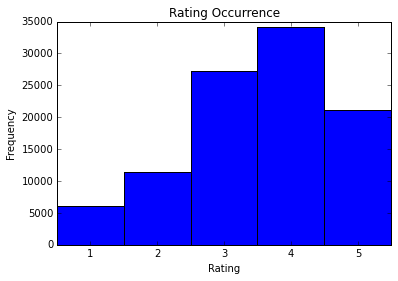

In [3]:
# Rating distribution
x = ratings.flat
his = np.histogram(x, bins = range(1,7))
fig, ax = plt.subplots()
offset = 0.5
plt.bar(his[1][1:],his[0],width=1)
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6') )
plt.title("Rating Occurrence")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

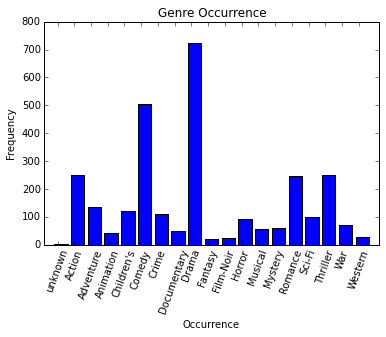

In [4]:
# Genre Distribution
genres = np.genfromtxt('ml-100k/u.item', delimiter='|', usecols=range(5, 24))
genre_names = np.genfromtxt('ml-100k/u.genre', delimiter='|', dtype=str, usecols=0)
x = np.sum(genres, axis=0)
his = np.histogram(x, bins = range(0,20))
fig, ax = plt.subplots()
offset = -.2
plt.bar(his[1][1:],x,align='center')
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels((list(genre_names)))
locs, labels = plt.xticks()
plt.setp(labels, rotation=70)
plt.title("Genre Occurrence")
plt.xlabel("Occurrence")
plt.ylabel("Frequency")
plt.show()

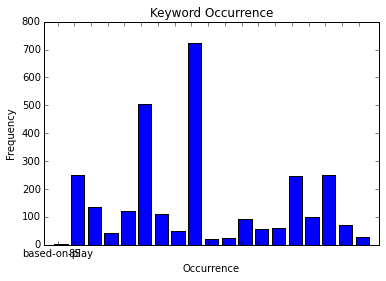

In [5]:
# Top 20 Keyword Distribution
keyword_matrix = np.genfromtxt('postprocessed-data/keywords_matrix', delimiter=',', dtype=int)
keywords = np.genfromtxt('postprocessed-data/keyword_list', dtype=str)
com = np.column_stack((keywords, np.sum(keyword_matrix, axis=0)))
com = com[np.argsort(np.argsort(com[:, 1]))][::-1]
com = com[range(0,20)]
his = np.histogram(x, bins = range(0,20))
fig, ax = plt.subplots()
offset = -.2
plt.bar(his[1][1:],x,align='center')
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels((list(com[0])))
locs, labels = plt.xticks()
plt.title("Keyword Occurrence")
plt.xlabel("Occurrence")
plt.ylabel("Frequency")
plt.show()

In [6]:
# Error distribution

In [7]:
# Loading user matrix
user_id = 945
user_matrix = um.get_user_matrix(user_id)
user_ratings = ratings[user_id-1]

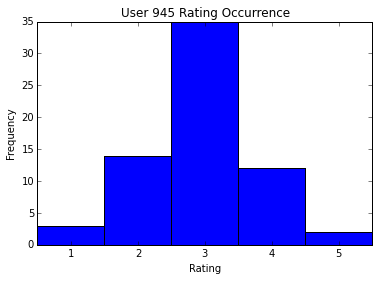

In [8]:
# User rating distribution
x = user_ratings
his = np.histogram(x, bins = range(1,7))
fig, ax = plt.subplots()
offset = 0.5
plt.bar(his[1][1:],his[0],width=1)
ax.set_xticks(his[1][1:] + offset)
ax.set_xticklabels( ('1', '2', '3', '4', '5', '6') )
plt.title("User " + str(user_id) + " Rating Occurrence")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [9]:
# Creating model
clf =TransparentRidge(alpha=.05)
user_cols = user_matrix.shape[1]
data = user_matrix[:, 1:(user_cols-1)]
target = user_matrix[:, (user_cols-1)]
clf.fit(data,target)
weights = clf.coef_
neg_evi, pos_evi = clf.predict_evidences(data)
bias = clf.get_bias()
y_pred = clf.predict(data)
indices = np.argsort(y_pred)
coef_diags = diags(clf.coef_, 0)
dm = data * coef_diags

In [10]:
# The Highest Rating
j = indices[-1]
movie_id = user_matrix[j][0]
res = um.get_avg_rating_for_movie(ratings, movie_id-1)
avg_rating = res[0]
num_rating = res[1]
movie_features = ur.gen_movie_weights(movie_id,dm,user_matrix)

print "Movie Title: ", movies[movie_id-1]
print "User Rating: ", user_ratings[movie_id-1]
print "Average Rating: ", avg_rating
print "Number of Ratings: ", num_rating
print "Prediction: ",  clf.predict(data[j])[0]
print "Bias and evidences:", bias, neg_evi[j], pos_evi[j]
print "Positive Features"
print "Weights: ", movie_features[2]
print movie_features[0].head(10)
print "Negative Features"
print movie_features[1].head(10)

IndexError: too many indices for array

In [18]:
# The Lowest Rating
j = indices[0]
movie_id = user_matrix[j][0]
res = um.get_avg_rating_for_movie(ratings, movie_id-1)
avg_rating = res[0]
num_rating = res[1]
movie_features = ur.gen_movie_weights(movie_id,dm,user_matrix)
print "Movie Title: ", movies[movie_id-1]
print "User Rating: ", user_ratings[movie_id-1]
print "Average Rating: ", avg_rating
print "Number of Ratings: ", num_rating
print "Prediction: ",  clf.predict(data[j])[0]
print "Bias and evidences:", bias, neg_evi[j], pos_evi[j]
print "Positive Features"
print movie_features[0].head(10)
print "Negative Features"
print movie_features[1].head(10)

In [19]:
# The case that has the most negative evidence, regardless of positive evidence
j = np.argsort(neg_evi)[0]
movie_id = user_matrix[j][0]
res = um.get_avg_rating_for_movie(ratings, movie_id-1)
avg_rating = res[0]
num_rating = res[1]
movie_features = ur.gen_movie_weights(movie_id,dm,user_matrix)
print "Movie Title: ", movies[movie_id-1]
print "User Rating: ", user_ratings[movie_id-1]
print "Average Rating: ", avg_rating
print "Number of Ratings: ", num_rating
print "Prediction: ",  clf.predict(data[j])[0]
print "Bias and evidences:", bias, neg_evi[j], pos_evi[j]
print "Positive Features"
print movie_features[0].head(10)
print "Negative Features"
print movie_features[1].head(10)

In [20]:
# The case that has the most positive evidence, regardless of negative evidence
j = np.argsort(pos_evi)[-1]
movie_id = user_matrix[j][0]
res = um.get_avg_rating_for_movie(ratings, movie_id-1)
avg_rating = res[0]
num_rating = res[1]
movie_features = ur.gen_movie_weights(movie_id,dm,user_matrix)
print "Movie Title: ", movies[movie_id-1]
print "User Rating: ", user_ratings[movie_id-1]
print "Average Rating: ", avg_rating
print "Number of Ratings: ", num_rating
print "Prediction: ",  clf.predict(data[j])[0]
print "Bias and evidences:", bias, neg_evi[j], pos_evi[j]
print "Positive Features"
print movie_features[0].head(10)
print "Negative Features"
print movie_features[1].head(10)

In [21]:
# Most conflicted
conflict = np.min([abs(neg_evi), pos_evi], axis=0)
indices = np.argsort(conflict)
j=indices[-1]
movie_id = user_matrix[j][0]
res = um.get_avg_rating_for_movie(ratings, movie_id-1)
avg_rating = res[0]
num_rating = res[1]
movie_features = ur.gen_movie_weights(movie_id,dm,user_matrix)
print "Movie Title: ", movies[movie_id-1]
print "User Rating: ", user_ratings[movie_id-1]
print "Average Rating: ", avg_rating
print "Number of Ratings: ", num_rating
print "Prediction: ",  clf.predict(data[j])[0]
print "Bias and evidences:", bias, neg_evi[j], pos_evi[j]
print "Positive Features"
print movie_features[0].head(10)
print "Negative Features"
print movie_features[1].head(10)

In [22]:
# Least amount of info
information = np.max([abs(neg_evi), pos_evi], axis=0)
indices = np.argsort(information)
j=indices[0]
movie_id = user_matrix[j][0]
res = um.get_avg_rating_for_movie(ratings, movie_id-1)
avg_rating = res[0]
num_rating = res[1]
movie_features = ur.gen_movie_weights(movie_id,dm,user_matrix)
print "Movie Title: ", movies[movie_id-1]
print "User Rating: ", user_ratings[movie_id-1]
print "Average Rating: ", avg_rating
print "Number of Ratings: ", num_rating
print "Prediction: ",  clf.predict(data[j])[0]
print "Bias and evidences:", bias, neg_evi[j], pos_evi[j]
print "Positive Features"
print movie_features[0].head(10)
print "Negative Features"
print movie_features[1].head(10)

Movie Title:  Return of the Pink Panther, The (1974)
User Rating:  3
Average Rating:  3.54838709677
Number of Ratings:  93
Prediction:  3.17226003094
Bias and evidences: 3.19221026975 -0.0831241817808 0.0631739429755
Positive Features
          Feature  Weights
0          Comedy   0.0446
1  Average Rating   0.0331
Negative Features
Empty DataFrame
Columns: [Feature, Weights]
Index: []
